## Experiments to see if Language model knows images through text


In [7]:
import re
import os
import openai
import pickle
import backoff 
import requests
import torch
import torch.nn as nn
import torch.nn.functional as F
from datasets import load_dataset, DatasetDict
from torchvision import datasets as torch_datasets
from torchvision import transforms as torch_transforms
import matplotlib.pyplot as plt
from transformers import ViTImageProcessor, ViTForImageClassification, ViTModel, ViTConfig
from PIL import Image
from tqdm import tqdm
import json

In [2]:
MODEL = "gpt-4" # 'gpt-3.5-turbo'

### Can GPT-4 draw ?

In [3]:
question = '''
Image of a vertical line is like this 
0 1 0 \n 
0 1 0 \n 
0 1 0 \n 
give me a image of a horizontal line in bottom"
'''
prompt=f"Question: {question}\nAnswer:"

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[{'role': 'user', 'content': prompt}]
)

ans = response.choices[0]
print(ans['message']['content'])

0 0 0

0 0 0

1 1 1


### MNIST classification ?

In [7]:
transform=torch_transforms.Compose([
        torch_transforms.ToTensor(),
        ])
mnist_data = torch_datasets.MNIST('./data', train=False, download=True, transform=transform)

In [111]:
def img2txt(img):
    #gray scale img to text
    txt = ''
    for y in range(img.shape[1]):
        for x in range(img.shape[2]):
            ii = img[0, y, x]
            if ii.item() >= 0.5:
                txt += '1'
            else:
                txt += '0'
        txt+='\n'
    return txt, img.shape

def txt2img(txt):
    x = txt.find('\n')
    y = txt.count('\n') + 2 #first and last row
    shape = (1, y, x)
    img = torch.zeros(shape)
    xi, yi = 0, 0
    for idx, tt in enumerate(txt):
        if tt == '\n':
            yi += 1
            xi = 0
        else:
            tt = tt if tt.isdigit() else 9
            img[0, yi, xi] = int(tt)
            xi += 1
    return img


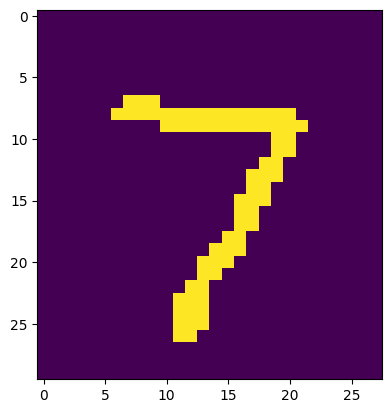

In [77]:
img = mnist_data[0][0]
txt, shp = img2txt(img)
igg = txt2img(txt)
plt.imshow(igg.permute(1, 2, 0))

In [50]:
question = f"What number is in this image {txt}"
prompt=f"Question: {question}\nAnswer:"

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[{'role': 'user', 'content': prompt}]
)

ans = response.choices[0]
print(ans['message']['content'])

Based on the provided image, it appears to represent the number 7.


### MNIST generation ?

In [9]:
question = f"Image of number seven is like this {txt} give me a image of number 8"
prompt=f"Question: {question}\nAnswer:"

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[{'role': 'user', 'content': prompt}]
)

ans = response.choices[0]
print(ans['message']['content'])

I'm an AI language model, and I cannot create images directly. However, I can help you create an ASCII representation of the number 8, like this:

```
0000000000000000000000000
0000000001111100000000000
0000000111111111000000000
0000001111111111100000000
0000011100000011110000000
0000011000000001110000000
0000111000000000111000000
0000110000000000111000000
0000110000000000011000000
0000011000000000110000000
0000011100000001110000000
0000001111111111100000000
0000000111111111000000000
0000001111111111100000000
0000011100000011110000000
0000011000000001110000000
0000111000000000111000000
0000110000000000111000000
0000110000000000011000000
0000011000000000110000000
0000011100000001110000000
0000001111111111100000000
0000000111111111000000000
0000000001111100000000000
0000000000000000000000000
```


### More than numbers, maybe FashionMNIST ?

In [54]:
transform=torch_transforms.Compose([
        torch_transforms.ToTensor(),
        ])
fashion_data = torch_datasets.FashionMNIST('./data', train=False, download=True, transform=transform)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



In [79]:
def img2txt_v2(img):
    #gray scale img to text
    #v2: convert float to digit eg: 0.4 -> 4
    txt = ''
    for y in range(img.shape[1]):
        for x in range(img.shape[2]):
            ii = img[0, y, x]
            digit = int(ii.item()*10)
            digit = digit if digit < 10 else 9
            txt += str(digit)
        txt+='\n'
    return txt, img.shape

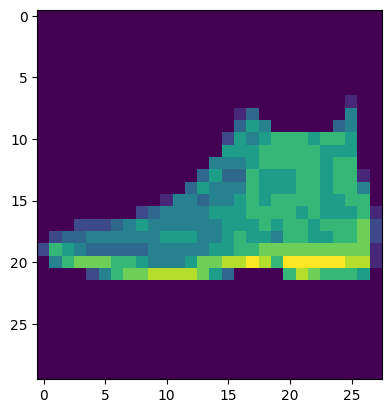

In [164]:
img = fashion_data[0][0] #shoe
txt, shp = img2txt_v2(img)
img = fashion_data[2][0] #pants
txt2, shp = img2txt_v2(img)
img = fashion_data[4][0] # shirt
txt3, shp = img2txt_v2(img)
img = fashion_data[31][0]
txt4, shp = img2txt_v2(img) # purse

igg = txt2img(txt)
plt.imshow(igg.permute(1, 2, 0))

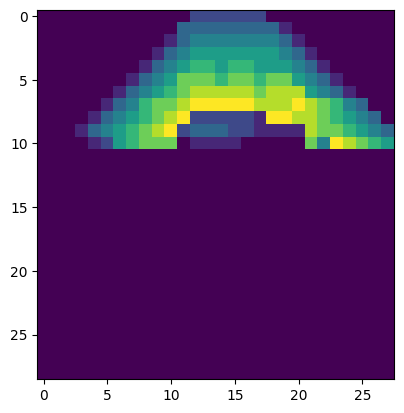

In [185]:
# try generation
context = f'''Each element of text array is a number between 0 to 9. 
The numbers represent pixel intensity, 
where 0 is the less intense and 9 is the most intense. 
This is a representation of a shoe {txt}. 
A representation of pants {txt2}
A representation of a shirt {txt3}
A representation of a bag {txt4}
'''
question = f"Give me a representation of a hat"
prompt=f"Context: {context}\nQuestion: {question}\nAnswer:"

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[{'role': 'user', 'content': prompt}]
)

ans = response.choices[0]
igg = txt2img(ans['message']['content'])
plt.imshow(igg.permute(1, 2, 0))

In [150]:
# try classification
img = fashion_data[76][0] #pants
txt5, shp = img2txt_v2(img)

context = f'''Each element of text array is a number between 0 to 9. 
The numbers represent pixel intensity, 
where 0 is the less intense and 9 is the most intense. 
This is a representation of a shoe {txt}. 
A representation of pants {txt2}
A representation of a shirt {txt3}
A representation of a bag {txt4}
'''
question = f"What this {txt5} represents"
prompt=f"Context: {context} \n Question: {question} \nAnswer:"

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[{'role': 'user', 'content': prompt}]
)

ans = response.choices[0]
print(ans['message']['content'])

pants


### How about Embeddings?

In [4]:
def get_qint8_embedding(outputs):
    # https://github.com/huggingface/transformers/blob/v4.27.1/src/transformers/models/vit/modeling_vit.py#L749
    embeding = outputs[:, 0, :]

    # https://docs.nvidia.com/deeplearning/tensorrt/tensorflow-quantization-toolkit/docs/docs/intro_to_quantization.html
    beta = -15
    alpha = 15
    scale = (alpha - beta) / 255
    zero_point = -round(beta * scale) - 128
    q_embeding = torch.quantize_per_tensor(embeding, scale, zero_point, torch.qint8)
    return q_embeding

def qint8_emb2txt(emb):
    #1-d embedding
    txt = ''
    for x in range(emb.shape[1]):
        ii = emb[0, x]
        digit = ii.item()
        txt += str(digit) + ', '
    txt = txt.rstrip(', ')
    return txt, emb.shape

def float_emb2txt(emb):
    txt = ''
    for x in range(emb.shape[1]):
        ii = emb[0, x]
        digit = ii.item()
        txt += "%.1f" % round(digit, 1) + ', '
    txt = txt.rstrip(', ')
    return txt, emb.shape

processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224')

In [9]:
image = Image.open('images/dog.jpg')
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)

predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

emb = get_qint8_embedding(outputs.hidden_states[-1])
txt_emb_dog, _ = qint8_emb2txt(emb)


Predicted class: Samoyed, Samoyede


In [10]:
image = Image.open('images/cat.jpg')
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)
predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

emb = get_qint8_embedding(outputs.hidden_states[-1])
txt_emb_cat, _ = qint8_emb2txt(emb)


Predicted class: tabby, tabby cat


In [11]:
image = Image.open('images/cat1.jpg')
inputs = processor(images=image, return_tensors="pt")
outputs = model(**inputs, output_hidden_states=True)
predicted_class_idx = outputs.logits.argmax(-1).item()
print("Predicted class:", model.config.id2label[predicted_class_idx])

emb = get_qint8_embedding(outputs.hidden_states[-1])
txt_emb_cat1, _ = qint8_emb2txt(emb)


Predicted class: tabby, tabby cat


In [13]:
context = f''' 
{txt_emb_cat} represents cat. 
{txt_emb_dog} represents dog. 
'''
question = f"Does this {txt_emb_cat1} represents a dog or a cat"
prompt=f"Context: {context} \n Question: {question} \nAnswer:"

response = openai.ChatCompletion.create(
    model=MODEL,
    messages=[{'role': 'user', 'content': prompt}]
)

ans = response.choices[0]
print(ans['message']['content'])

This representation represents a cat.


### fine-tune with embeddings

In [5]:
#create dataset for finetune LM
txtlabel = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
transform=torch_transforms.Compose([
        torch_transforms.ToTensor(),
        ])
cifar10_data = torch_datasets.CIFAR10('./data', train=False, download=True, transform=transform)

device = "cuda" if torch.cuda.is_available() else "cpu"
model = model.to(device)

Files already downloaded and verified


In [ ]:
sub_set = len(cifar10_data)//10 
data_gpt = []
for idx in tqdm(range(sub_set)):
    image, label = cifar10_data[idx]
    inputs = processor(images=image, return_tensors="pt")
    inputs = inputs.to(device)
    outputs = model(**inputs, output_hidden_states=True)
    emb = get_qint8_embedding(outputs.hidden_states[-1])
    txt_emb, _ = qint8_emb2txt(emb)
    data_gpt.append({"prompt": "{} represents".format(txt_emb), 
                     "completion": txtlabel[label]})
    

In [8]:
with open('metadata.jsonl', "w", encoding="utf-8") as f:
    for item in data_gpt:
        f.write(json.dumps(item) + "\n")

In [ ]:
# fine tune following command line: https://platform.openai.com/docs/guides/fine-tuning